In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
from google.colab import files
uploaded2 = files.upload()

Saving test.csv to test.csv


In [ ]:
import io
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
test = pd.read_csv(io.BytesIO(uploaded2['test.csv']))

In [ ]:
print('the shape of train is ', train.shape)
print('the shape of test is ', test.shape)

the shape of train is  (7613, 5)
the shape of test is  (3263, 4)


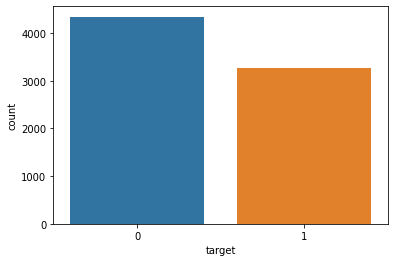

In [ ]:
sns.countplot(train['target'])

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenization

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text) #tokenize the text
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"] #add special tokens needed for sentence classifications (these are [CLS] at the first position, and [SEP] at the end of the sentence).
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)#The third step the tokenizer does is to replace each token with its id from the embedding table
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids") #input to the model contains input ids, mask and segment ids
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [ ]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=8
)

Epoch 1/3
762/762 [==============================] - 1272s 2s/step - loss: 0.4449 - accuracy: 0.8003 - val_loss: 0.3889 - val_accuracy: 0.8319
Epoch 2/3
762/762 [==============================] - 1267s 2s/step - loss: 0.3044 - accuracy: 0.8755 - val_loss: 0.4022 - val_accuracy: 0.8319
Epoch 3/3
762/762 [==============================] - 1267s 2s/step - loss: 0.2107 - accuracy: 0.9154 - val_loss: 0.4285 - val_accuracy: 0.8286


In [ ]:
test_pred = model.predict(test_input)

In [ ]:
submission=pd.DataFrame()
submission['id']=test['id']
submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)

In [ ]:
from google.colab import files
files.download('submission.csv')

In [ ]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
